# RUN THIS: IMPORT EVERYTHING

In [0]:
#ALL Imports

from sklearn.preprocessing import FunctionTransformer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

from sklearn import preprocessing

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_fscore_support as score

import spacy
import json

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Run This: SpaCy and Tokenize Normalize Functions

In [0]:
#!python -m spacy download en


# Load the small english model. 
# Disable the advanced NLP features in the pipeline for efficiency.
nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')





('parser', <spacy.pipeline.DependencyParser at 0x7fd5f74d1830>)

In [0]:
#@Tokenize
def spacy_tokenize(string):
  tokens = list()
  doc = nlp(string)
  for token in doc:
    tokens.append(token)
  return tokens

#@Normalize
def normalize(tokens):
  normalized_tokens = list()
  for token in tokens:
    if (token.is_alpha or token.is_digit):
      normalized = token.text.lower().strip()
      normalized_tokens.append(normalized)
  return normalized_tokens

#@Tokenize and normalize
def tokenize_normalize(string):
  return normalize(spacy_tokenize(string))  




## ItemSelector

In [0]:

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.    """

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]
      

## Run this evaluation summary & confusion matrix function & create plots

In [0]:

def plot_conf_matrix(test_labels, prediction, classes, title):
  conf_arr = confusion_matrix(test_labels, prediction)
  # print(conf_arr[0].size)
  norm_conf = []
  for i in conf_arr:
      a = 0
      tmp_arr = []
      a = sum(i, 0)
      for j in i:
          tmp_arr.append(float(j)/float(a))
      norm_conf.append(tmp_arr)
  # print(norm_conf)
  fig = plt.figure(figsize=(10, 6))
  plt.clf()
  ax = fig.add_subplot(111)
  ax.set_aspect(1)
  res = ax.imshow(np.array(norm_conf), cmap=plt.cm.terrain, 
                  interpolation='nearest')

  width, height = conf_arr.shape

  for x in range(width):
      for y in range(height):
          ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                      horizontalalignment='center',
                      verticalalignment='center')

  cb = fig.colorbar(res)
  cb.set_label('$Probability$')
  cb.set_ticks(np.linspace(0,1,11))
  # cb.set_ticklabels(('0','50','100','150','200','250','300','70','80','90','100'))
  classes = classes
  plt.xticks(range(width), classes[:width],rotation='vertical')
  plt.yticks(range(height), classes[:height])
  plt.grid(axis="y")
  plt.grid(axis="x")
  plt.ylabel='True Label'
  plt.xlabel = 'Predicted Label'
  plt.title = title
  
  name = title+'confusion_matrix.png'
  plt.savefig(name, format='png')

#@title Run this confusion matrix function
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
  
  

def create_plot(text, model, prediction, test_labels):
  precision, reacall, fscore, support = score(prediction,test_labels)

  bars = np.arange(len(model.classes_))
  classes = model.classes_
  width=.4
  fig, ax=plt.subplots(1,1,figsize=(8,6))
  rects1 = ax.bar(bars, fscore, width)

  ax.set_ylabel('F1')
  ax.set_title(text)
  ax.set_xticks(bars+width/3)
  plt.xticks(rotation='vertical')
  ax.set_xticklabels(classes)

  plt.show()


  
def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision = precision_score(predictions, true_labels, average='macro')
  recall = recall_score(predictions, true_labels, average='macro')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1,average='macro') #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
  print(classification_report(predictions, true_labels, digits=3))
  print('\nConfusion matrix:\n',confusion_matrix(y_true=true_labels, y_pred=predictions))#,labels=true_labels)) # Note the order here is true, predicted, odd.



# Part A: Subreddit Prediction ##

#Q1

## Preprocess

In [0]:
subreddit_train = "coursework_subreddit_train.json"
subreddit_test = "coursework_subreddit_test.json"

!gsutil cp gs://textasdata/coursework/coursework_subreddit_train.json $subreddit_train 
!gsutil cp gs://textasdata/coursework/coursework_subreddit_test.json  $subreddit_test

Copying gs://textasdata/coursework/coursework_subreddit_train.json...
/ [1 files][ 10.1 MiB/ 10.1 MiB]                                                
Operation completed over 1 objects/10.1 MiB.                                     
Copying gs://textasdata/coursework/coursework_subreddit_test.json...
/ [1 files][  2.7 MiB/  2.7 MiB]                                                
Operation completed over 1 objects/2.7 MiB.                                      


In [0]:
import pandas as pd

## threads

train_threads = pd.read_json(path_or_buf=subreddit_train, lines=True)
print(list(train_threads.columns.values))
print(train_threads.head())
print(train_threads.size)

['is_self_post', 'posts', 'subreddit', 'title', 'url']
   is_self_post                                              posts  \
0           1.0  [{'body': 'I think everyone has that one frien...   
1           1.0  [{'body': 'I not 100% sure this is the right p...   
2           1.0  [{'body': '', 'author': 'Leisure321', 'url': '...   
3           1.0  [{'body': 'It's called 'forgetting things'.', ...   
4           1.0  [{'body': 'How would I do this? I am looking t...   

        subreddit                                              title  \
0   relationships  How do I [23F] communicate with my self-center...   
1  summonerschool  What Cherry switch do you recommend for League...   
2       askreddit                   Where do memes go when they die?   
3           trees                     Some weird long term affects??   
4        buildapc  Simple question: If I install Windows to a sta...   

                                                 url  
0  https://www.reddit.com/r/relation

In [0]:
print(train_threads.shape)
train_threads.head()


(1456, 5)


,is_self_post,posts,subreddit,title,url
0,1.0,[{'body': 'I think everyone has that one frien...,relationships,How do I [23F] communicate with my self-center...,https://www.reddit.com/r/relationships/comment...
1,1.0,[{'body': 'I not 100% sure this is the right p...,summonerschool,What Cherry switch do you recommend for League...,https://www.reddit.com/r/summonerschool/commen...
2,1.0,"[{'body': '', 'author': 'Leisure321', 'url': '...",askreddit,Where do memes go when they die?,https://www.reddit.com/r/AskReddit/comments/4d...
3,1.0,"[{'body': 'It's called 'forgetting things'.', ...",trees,Some weird long term affects??,https://www.reddit.com/r/trees/comments/1h300m...
4,1.0,[{'body': 'How would I do this? I am looking t...,buildapc,Simple question: If I install Windows to a sta...,https://www.reddit.com/r/buildapc/comments/jhb...


In [0]:
test_threads = pd.read_json(path_or_buf=subreddit_test, lines=True)
print(test_threads.head())
print(test_threads.size)

   is_self_post                                              posts  \
0           1.0  [{'body': 'Was watching a VOD from last years ...   
1           1.0  [{'body': 'Basically what the title says.', 'u...   
2           1.0  [{'body': '', 'author': 'Daft-Punk', 'url': 'h...   
3           1.0  [{'body': 'I start running this year. I do it ...   
4           1.0  [{'body': '[deleted]', 'url': 'https://www.red...   

       subreddit                                              title  \
0      starcraft  Just a reminder on how much SC2 has evolved th...   
1    whowouldwin  Your Favorite Hero Now Has A Healing Factor As...   
2      askreddit  If you could live anywhere in the world, where...   
3      askreddit                   Do you ever get use to exercise?   
4  tipofmytongue         [TOMT] [book] A scary french book for kids   

                                                 url  
0  https://www.reddit.com/r/starcraft/comments/mq...  
1  https://www.reddit.com/r/whowouldwin/co

In [0]:
subreddit_counts = train_threads['subreddit'].value_counts()
print(subreddit_counts.describe())
top_subbreddits = subreddit_counts.nlargest(20)
top_subbreddits_list = top_subbreddits.index.tolist()
print(top_subbreddits)
print(top_subbreddits_list)

count     20.000000
mean      72.800000
std       73.368285
min       28.000000
25%       36.250000
50%       45.500000
75%       63.750000
max      334.000000
Name: subreddit, dtype: float64
askreddit               334
leagueoflegends         196
buildapc                131
explainlikeimfive        82
trees                    66
techsupport              63
gaming                   62
pcmasterrace             62
electronic_cigarette     59
relationships            48
tipofmytongue            43
jailbreak                38
hearthstone              38
summonerschool           37
atheism                  37
reddit.com               34
movies                   33
whowouldwin              33
personalfinance          32
starcraft                28
Name: subreddit, dtype: int64
['askreddit', 'leagueoflegends', 'buildapc', 'explainlikeimfive', 'trees', 'techsupport', 'gaming', 'pcmasterrace', 'electronic_cigarette', 'relationships', 'tipofmytongue', 'jailbreak', 'hearthstone', 'summonerschool'

## Train & test data frame creation

In [0]:

def create_threads_frame(subreddit_file):
  
  posts = list()

  # If the dataset is too large, you can load a subset of the posts.
  post_limit = 100000000

  # Construct a dataframe, by opening the JSON file line-by-line
  with open(subreddit_file) as jsonfile:
    for i, line in enumerate(jsonfile):
      thread = json.loads(line)
      if (len(posts) > post_limit):
        break
      sub=''
      title=''
      url=''
      id_=''
      author=''
      body=''
      
      for post in thread['posts']:
        sub =thread['subreddit']
        title = thread['title']
        url = thread['url']
        id_ += " | " +post.get('id',"")
        author+= " | " + post.get('author', "")
        body+=" | " +post.get('body', "")
        
      posts.append((sub, title, url, id_, author, body))


  labels = ['subreddit', 'title', 'url', 'id', 'author', 'body']
  return(pd.DataFrame(posts, columns=labels))



In [0]:
train_threads_frame = create_threads_frame(subreddit_train)
test_threads_frame = create_threads_frame(subreddit_test)


In [0]:
train_threads_frame.head()

,subreddit,title,url,id,author,body
0,relationships,How do I [23F] communicate with my self-center...,https://www.reddit.com/r/relationships/comment...,| t1_covzqua | t1_cow04yo | t1_cow4211 | t1_c...,| Pouritdownmythroat | WhyFrankWhy | Pouritdo...,| I think everyone has that one friend who lo...
1,summonerschool,What Cherry switch do you recommend for League...,https://www.reddit.com/r/summonerschool/commen...,| t3_2w8jon | t1_cooiwv5 | t1_coojoh9 | t1_co...,| | | ThisGermanGuy | shaunrnm | Sub_Salac ...,| I not 100% sure this is the right place to ...
2,askreddit,Where do memes go when they die?,https://www.reddit.com/r/AskReddit/comments/4d...,| t3_4dr951 | t1_d1tjpa2 | t1_d1tjolo | t1_d1...,| Leisure321 | Zeolance | | Buttersgoo23 | q...,| | Facebook | | 9gag | Memes never truly d...
3,trees,Some weird long term affects??,https://www.reddit.com/r/trees/comments/1h300m...,| t1_caqbp3q | t1_caqbzo7 | t1_caqcfm5,| refugee4chan | donquixote6179 | ThatStonedA...,| It's called 'forgetting things'. | Dude i d...
4,buildapc,Simple question: If I install Windows to a sta...,https://www.reddit.com/r/buildapc/comments/jhb...,| t3_jhbqc | t1_c2c566a | t1_c2c3s12 | t1_c2c...,| catalyzeme | uses | rvabdn | greg2709 | spy...,| How would I do this? I am looking to wait a...


## Set train and test labels

In [0]:
train_labels = train_threads_frame['subreddit']
test_labels = test_threads_frame['subreddit']

In [0]:
 sub_classes=[ 'askreddit','atheism','buildapc','electronic_cigarette','explainlikeimfive', 'gaming',     
         'hearthstone','jailbreak','leagueoflegends','movies','pcmasterrace','personalfinance','reddit.com','relationships','starcraft','summonerschool','techsupport',     
       'tipofmytongue',  'trees', 'whowouldwin' ]

## One-hot encoding

### Hstack

Vectorize features independently and combine them using an HStack

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

from scipy import sparse


one_hot_vectorizer = CountVectorizer(tokenizer=tokenize_normalize,binary=True)
train_features_onehot_body =one_hot_vectorizer.fit_transform(train_threads_frame.body)
test_features_onehot_body = one_hot_vectorizer.transform(test_threads_frame.body)


train_features_onehot_auth =one_hot_vectorizer.fit_transform(train_threads_frame.author)
test_features_onehot_auth = one_hot_vectorizer.transform(test_threads_frame.author)


train_features_onehot_title =one_hot_vectorizer.fit_transform(train_threads_frame.title)
test_features_onehot_title = one_hot_vectorizer.transform(test_threads_frame.title)

train_features_onehot =sparse.hstack([train_features_onehot_body,train_features_onehot_auth,train_features_onehot_title])

test_features_onehot = sparse.hstack([test_features_onehot_body,test_features_onehot_auth,test_features_onehot_title])


### Logistic Regression

In [0]:

## one-hot and logistic regression
lr = LogisticRegression(solver='saga')
lr_model = lr.fit(train_features_onehot,train_labels)
lr_predict1 = lr.predict(test_features_onehot)
evaluation_summary("LR One-Hot Encoding", lr_predict1, test_labels)                   

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: LR One-Hot Encoding
Classifier 'LR One-Hot Encoding' has Acc=0.688 P=0.578 R=0.717 F1=0.607
                      precision    recall  f1-score   support

           askreddit      0.929     0.667     0.776       117
             atheism      0.500     0.857     0.632         7
            buildapc      0.784     0.806     0.795        36
electronic_cigarette      0.889     0.800     0.842        10
   explainlikeimfive      0.786     0.611     0.688        18
              gaming      0.412     0.389     0.400        18
         hearthstone      0.467     1.000     0.636         7
           jailbreak      0.545     0.750     0.632         8
     leagueoflegends      0.896     0.581     0.705        74
              movies      0.400     1.000     0.571         2
        pcmasterrace      0.217     0.625     0.323         8
     personalfinance      0.900     1.000     0.947         9
          reddit.com      0.000     0.000     0.000         0
       relationships   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### Plot results

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


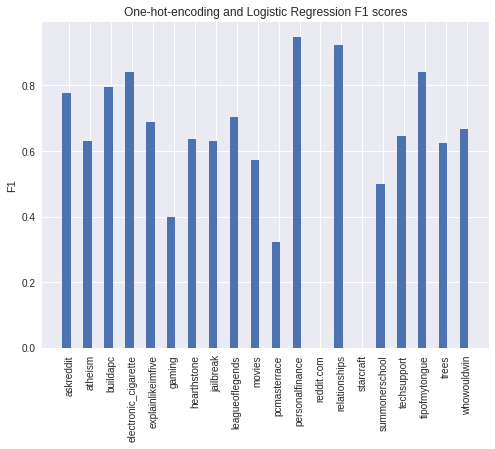

In [0]:
create_plot('One-hot-encoding and Logistic Regression F1 scores', lr_model, lr_predict1, test_labels)

Confusion matrix, without normalization


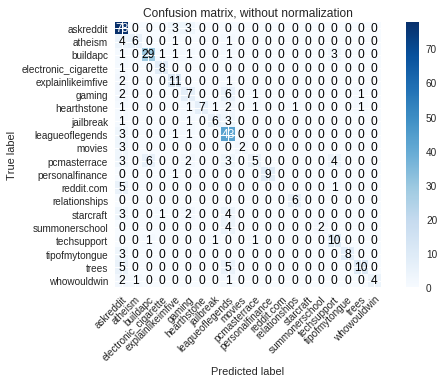

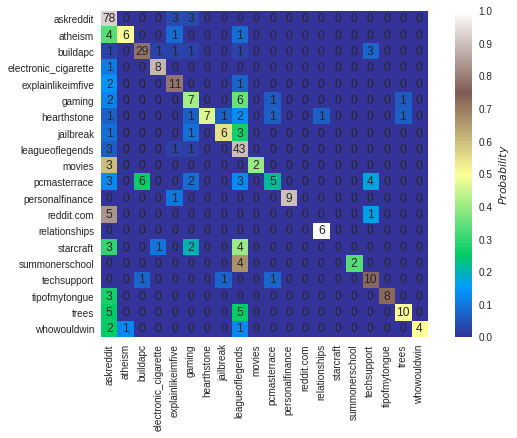

In [0]:
plot_confusion_matrix(test_labels, lr_predict1, sub_classes,title='Confusion matrix, without normalization')
plot_conf_matrix(test_labels,lr_predict1, sub_classes, title= 'One-hot LR Confusion Matrix')

### SVC

In [0]:

svc1 = SVC(gamma='auto',kernel='rbf')
svc_model1 = svc1.fit(train_features_onehot,train_labels)
svc_predict1= svc1.predict(test_features_onehot)
evaluation_summary("SVC One-Hot Encoding", svc_predict1, test_labels) 

Evaluation for: SVC One-Hot Encoding
Classifier 'SVC One-Hot Encoding' has Acc=0.230 P=0.050 R=0.012 F1=0.019
                      precision    recall  f1-score   support

           askreddit      1.000     0.230     0.374       365
             atheism      0.000     0.000     0.000         0
            buildapc      0.000     0.000     0.000         0
electronic_cigarette      0.000     0.000     0.000         0
   explainlikeimfive      0.000     0.000     0.000         0
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.000     0.000     0.000         0
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0
       relationships 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Naive Bayes

In [0]:
nb1 = BernoulliNB()
nb_model1 = nb1.fit(train_features_onehot, train_labels)
nb_predict1 = nb1.predict(test_features_onehot)
evaluation_summary("NB One-Hot Encoding", nb_predict1, test_labels) 

Evaluation for: NB One-Hot Encoding
Classifier 'NB One-Hot Encoding' has Acc=0.304 P=0.085 R=0.069 F1=0.063
                      precision    recall  f1-score   support

           askreddit      0.988     0.264     0.417       314
             atheism      0.000     0.000     0.000         0
            buildapc      0.541     0.714     0.615        28
electronic_cigarette      0.000     0.000     0.000         0
   explainlikeimfive      0.000     0.000     0.000         0
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.167     0.400     0.235        20
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0
       relationships   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Dummy Classifiers

In [0]:

dummy_mf1 = DummyClassifier(strategy='most_frequent')
dummy_mf1.fit(train_features_onehot, train_labels)
print(dummy_mf1.score(test_features_onehot, test_labels))
evaluation_summary("Dummy Majority", dummy_mf1.predict(test_features_onehot), test_labels)

0.23013698630136986
Evaluation for: Dummy Majority
Classifier 'Dummy Majority' has Acc=0.230 P=0.050 R=0.012 F1=0.019
                      precision    recall  f1-score   support

           askreddit      1.000     0.230     0.374       365
             atheism      0.000     0.000     0.000         0
            buildapc      0.000     0.000     0.000         0
electronic_cigarette      0.000     0.000     0.000         0
   explainlikeimfive      0.000     0.000     0.000         0
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.000     0.000     0.000         0
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0
       relati

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
dummy_prior1 = DummyClassifier(strategy='stratified')
dummy_prior1.fit(train_features_onehot, train_labels)
print(dummy_prior1.score(test_features_onehot, test_labels))
evaluation_summary("Dummy Prior", dummy_prior1.predict(test_features_onehot), test_labels)


0.0958904109589041
Evaluation for: Dummy Prior
Classifier 'Dummy Prior' has Acc=0.071 P=0.029 R=0.031 F1=0.030
                      precision    recall  f1-score   support

           askreddit      0.155     0.186     0.169        70
             atheism      0.000     0.000     0.000         8
            buildapc      0.054     0.059     0.056        34
electronic_cigarette      0.000     0.000     0.000        14
   explainlikeimfive      0.071     0.050     0.059        20
              gaming      0.059     0.053     0.056        19
         hearthstone      0.000     0.000     0.000        10
           jailbreak      0.000     0.000     0.000         8
     leagueoflegends      0.146     0.167     0.156        42
              movies      0.000     0.000     0.000        10
        pcmasterrace      0.087     0.105     0.095        19
     personalfinance      0.000     0.000     0.000         6
          reddit.com      0.000     0.000     0.000        10
       relationships

In [0]:
## define pipeline with one hot encoder

# Use FeatureUnion to combine the features from text and summary
one_hot_combined_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('one-hot', CountVectorizer(tokenizer=tokenize_normalize, binary=True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('one-hot', CountVectorizer(tokenizer=tokenize_normalize, binary=True)), 
              ])),
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('one-hot', CountVectorizer(tokenizer=tokenize_normalize, binary=True)), 
              ])),
        ])
        )
    ])

In [0]:
one_hot_train_features = one_hot_combined_pipeline.fit_transform(train_threads_frame)
one_hot_test_features = one_hot_combined_pipeline.transform(test_threads_frame)


In [0]:
## one-hot and logistic regression
lr = LogisticRegression(solver='saga')
lr_model = lr.fit(one_hot_train_features,train_labels)
lr_predict = lr.predict(one_hot_test_features)
evaluation_summary("LR One-Hot Encoding", lr_predict, test_labels)                   

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: LR One-Hot Encoding
Classifier 'LR One-Hot Encoding' has Acc=0.693 P=0.585 R=0.723 F1=0.613
                      precision    recall  f1-score   support

           askreddit      0.929     0.672     0.780       116
             atheism      0.500     0.857     0.632         7
            buildapc      0.784     0.806     0.795        36
electronic_cigarette      0.889     0.800     0.842        10
   explainlikeimfive      0.786     0.611     0.688        18
              gaming      0.471     0.421     0.444        19
         hearthstone      0.467     1.000     0.636         7
           jailbreak      0.545     0.750     0.632         8
     leagueoflegends      0.896     0.581     0.705        74
              movies      0.400     1.000     0.571         2
        pcmasterrace      0.217     0.714     0.333         7
     personalfinance      0.900     1.000     0.947         9
          reddit.com      0.000     0.000     0.000         0
       relationships   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
## one-hot and SVR

svc = SVC(gamma='auto',kernel='rbf')
svc_model = svc.fit(one_hot_train_features,train_labels)
svc_predict = svc.predict(one_hot_test_features)


In [0]:
evaluation_summary("SVC One-Hot Encoding", svc_predict, test_labels)                 

Evaluation for: SVC One-Hot Encoding
Classifier 'SVC One-Hot Encoding' has Acc=0.230 P=0.050 R=0.012 F1=0.019
                      precision    recall  f1-score   support

           askreddit      1.000     0.230     0.374       365
             atheism      0.000     0.000     0.000         0
            buildapc      0.000     0.000     0.000         0
electronic_cigarette      0.000     0.000     0.000         0
   explainlikeimfive      0.000     0.000     0.000         0
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.000     0.000     0.000         0
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0
       relationships 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
## one-hot and Naive Bayes

nb = BernoulliNB()
nb_model = nb.fit(one_hot_train_features, train_labels)
nb_predict = nb.predict(one_hot_test_features)
evaluation_summary("NB One-Hot Encoding", nb_predict, test_labels)           
print(nb_predict)

Evaluation for: NB One-Hot Encoding
Classifier 'NB One-Hot Encoding' has Acc=0.304 P=0.085 R=0.069 F1=0.063
                      precision    recall  f1-score   support

           askreddit      0.988     0.264     0.417       314
             atheism      0.000     0.000     0.000         0
            buildapc      0.541     0.714     0.615        28
electronic_cigarette      0.000     0.000     0.000         0
   explainlikeimfive      0.000     0.000     0.000         0
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.167     0.400     0.235        20
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0
       relationships   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
#dummy

##Solution

dummy_prior = DummyClassifier(strategy='stratified')
dummy_prior.fit(one_hot_train_features, train_labels)
print(dummy_prior.score(one_hot_test_features, test_labels))
evaluation_summary("Dummy Prior", dummy_prior.predict(one_hot_test_features), test_labels)



0.0684931506849315
Evaluation for: Dummy Prior
Classifier 'Dummy Prior' has Acc=0.071 P=0.032 R=0.035 F1=0.032
                      precision    recall  f1-score   support

           askreddit      0.167     0.206     0.184        68
             atheism      0.000     0.000     0.000        14
            buildapc      0.108     0.129     0.118        31
electronic_cigarette      0.000     0.000     0.000        14
   explainlikeimfive      0.000     0.000     0.000        19
              gaming      0.000     0.000     0.000        13
         hearthstone      0.000     0.000     0.000        11
           jailbreak      0.000     0.000     0.000        16
     leagueoflegends      0.104     0.100     0.102        50
              movies      0.000     0.000     0.000         7
        pcmasterrace      0.087     0.182     0.118        11
     personalfinance      0.000     0.000     0.000         9
          reddit.com      0.000     0.000     0.000         6
       relationships

In [0]:
dummy_mf = DummyClassifier(strategy='most_frequent')
dummy_mf.fit(one_hot_train_features, train_labels)
print(dummy_mf.score(one_hot_test_features, test_labels))
evaluation_summary("Dummy Majority", dummy_mf.predict(one_hot_test_features), test_labels)

0.23013698630136986
Evaluation for: Dummy Majority


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Classifier 'Dummy Majority' has Acc=0.230 P=0.050 R=0.012 F1=0.019
                      precision    recall  f1-score   support

           askreddit      1.000     0.230     0.374       365
             atheism      0.000     0.000     0.000         0
            buildapc      0.000     0.000     0.000         0
electronic_cigarette      0.000     0.000     0.000         0
   explainlikeimfive      0.000     0.000     0.000         0
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.000     0.000     0.000         0
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0
       relationships      0.000     0.000     0.000         0
  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## TFIDF 

All classifiers using TFIDF vectorizer

### Hstack

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

from scipy import sparse


tfidf_vectorizer =TfidfVectorizer(tokenizer=tokenize_normalize, binary=False)
train_features_tfidf_body =tfidf_vectorizer.fit_transform(train_threads_frame.body)
test_features_tfidf_body = tfidf_vectorizer.transform(test_threads_frame.body)


train_features_tfidf_auth =tfidf_vectorizer.fit_transform(train_threads_frame.author)
test_features_tfidf_auth = tfidf_vectorizer.transform(test_threads_frame.author)


train_features_tfidf_title =tfidf_vectorizer.fit_transform(train_threads_frame.title)
test_features_tfidf_title = tfidf_vectorizer.transform(test_threads_frame.title)

train_features_tfidf =sparse.hstack([train_features_tfidf_body,train_features_tfidf_auth,train_features_tfidf_title])

test_features_tfidf = sparse.hstack([test_features_tfidf_body,test_features_tfidf_auth,test_features_tfidf_title])


### Logistic Regression

In [0]:
## one-hot and logistic regression
lr2 = LogisticRegression(solver='saga')
lr_model2 = lr2.fit(train_features_tfidf,train_labels)
lr_predict2 = lr2.predict(test_features_tfidf)
evaluation_summary("LR TFIDF", lr_predict2, test_labels)                   


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.575 P=0.389 R=0.658 F1=0.423
                      precision    recall  f1-score   support

           askreddit      0.952     0.457     0.618       175
             atheism      0.083     1.000     0.154         1
            buildapc      0.838     0.816     0.827        38
electronic_cigarette      0.667     0.857     0.750         7
   explainlikeimfive      0.429     0.750     0.545         8
              gaming      0.118     0.400     0.182         5
         hearthstone      0.133     1.000     0.235         2
           jailbreak      0.273     1.000     0.429         3
     leagueoflegends      0.854     0.494     0.626        83
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.217     0.714     0.333         7
     personalfinance      0.700     1.000     0.824         7
          reddit.com      0.000     0.000     0.000         0
       relationships      1.000     1.000    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### SVC

In [0]:
svc2 = SVC(gamma='auto',kernel='rbf')
svc_model2 = svc2.fit(train_features_tfidf,train_labels)
svc_predict2= svc2.predict(test_features_tfidf)
evaluation_summary("SVC TFIDF", svc_predict2, test_labels) 


Evaluation for: SVC TFIDF
Classifier 'SVC TFIDF' has Acc=0.230 P=0.050 R=0.012 F1=0.019
                      precision    recall  f1-score   support

           askreddit      1.000     0.230     0.374       365
             atheism      0.000     0.000     0.000         0
            buildapc      0.000     0.000     0.000         0
electronic_cigarette      0.000     0.000     0.000         0
   explainlikeimfive      0.000     0.000     0.000         0
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.000     0.000     0.000         0
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0
       relationships      0.000     0.000  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Naive Bayes

In [0]:
nb2 = BernoulliNB()
nb_model2 = nb2.fit(train_features_tfidf, train_labels)
nb_predict2 = nb2.predict(test_features_tfidf)
evaluation_summary("NB TFIDF", nb_predict2, test_labels) 


Evaluation for: NB TFIDF
Classifier 'NB TFIDF' has Acc=0.304 P=0.085 R=0.069 F1=0.063
                      precision    recall  f1-score   support

           askreddit      0.988     0.264     0.417       314
             atheism      0.000     0.000     0.000         0
            buildapc      0.541     0.714     0.615        28
electronic_cigarette      0.000     0.000     0.000         0
   explainlikeimfive      0.000     0.000     0.000         0
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.167     0.400     0.235        20
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0
       relationships      0.000     0.000    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Dummy Classifiers

In [0]:
dummy_mf2 = DummyClassifier(strategy='most_frequent')
dummy_mf2.fit(train_features_tfidf, train_labels)
print(dummy_mf2.score(test_features_tfidf, test_labels))
evaluation_summary("Dummy Majority TFIDF", dummy_mf2.predict(test_features_tfidf), test_labels)

0.23013698630136986
Evaluation for: Dummy Majority TFIDF
Classifier 'Dummy Majority TFIDF' has Acc=0.230 P=0.050 R=0.012 F1=0.019
                      precision    recall  f1-score   support

           askreddit      1.000     0.230     0.374       365
             atheism      0.000     0.000     0.000         0
            buildapc      0.000     0.000     0.000         0
electronic_cigarette      0.000     0.000     0.000         0
   explainlikeimfive      0.000     0.000     0.000         0
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.000     0.000     0.000         0
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0
 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
dummy_prior2 = DummyClassifier(strategy='stratified')
dummy_prior2.fit(train_features_tfidf, train_labels)
print(dummy_prior2.score(test_features_tfidf, test_labels))
evaluation_summary("Dummy Prior TFIDF", dummy_prior2.predict(test_features_tfidf), test_labels)


0.0684931506849315
Evaluation for: Dummy Prior TFIDF
Classifier 'Dummy Prior TFIDF' has Acc=0.129 P=0.058 R=0.053 F1=0.055
                      precision    recall  f1-score   support

           askreddit      0.298     0.281     0.289        89
             atheism      0.083     0.111     0.095         9
            buildapc      0.081     0.088     0.085        34
electronic_cigarette      0.000     0.000     0.000        17
   explainlikeimfive      0.143     0.111     0.125        18
              gaming      0.000     0.000     0.000        12
         hearthstone      0.000     0.000     0.000        11
           jailbreak      0.000     0.000     0.000         8
     leagueoflegends      0.271     0.241     0.255        54
              movies      0.000     0.000     0.000         7
        pcmasterrace      0.000     0.000     0.000         7
     personalfinance      0.000     0.000     0.000         6
          reddit.com      0.000     0.000     0.000        12
       r

#Q2

Improving effectiveness. 
In this task your goal is to improve the effectiveness of a **baseline LogisticRegression with TF-IDF vectorization**.


## Parameter tuning
Required parameters: 
 -   C of logistic regression (typical values might be powers of 10 (from 10^-3 to 10^4)
 -   multi_class
 -   solver
  
Vectorizer parameters:
 -   sublinear_tf
 -   ngram_range (from one word up to length 3)
 -   max_feature (vocabulary size) for the three fields (None to approximately 50k)

### Parameters
An array of parameters for grid search, five different combinations

In [0]:

params = [
   {'classifier__C': (0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000)},
   #{'classifier__solver': ('newton-cg', 'lbfgs', 'sag', 'liblinear', 'saga')},
   
    {'union__body__tfidf__max_features': (None, 5000, 10000, 50000),
   'union__body__tfidf__ngram_range': ((1, 1),(1, 2), (1, 3)),
   'union__body__tfidf__sublinear_tf': (True, False)},
   
    {'union__title__tfidf__max_features': (None, 5000, 10000, 50000),
   'union__title__tfidf__ngram_range': ((1, 1),(1, 2), (1, 3)),
   'union__title__tfidf__sublinear_tf': (True, False)},
    {
  'classifier__multi_class': ('ovr', 'multinomial','auto'),
  'classifier__solver': ('newton-cg', 'lbfgs', 'sag', 'saga')},
   
    {'union__author__tfidf__max_features': (None, 5000, 10000, 50000),
   'union__author__tfidf__ngram_range': ((1, 1),(1, 2), (1, 3)),
   'union__author__tfidf__sublinear_tf': (True, False)}
 ]







### GridSearch

In [0]:

gridsearch_results = []
gridsearch_score = []
  
for param in params:
  grid_search = GridSearchCV(tfidf_pipeline_lr, param_grid=param, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in tfidf_pipeline_lr.steps])
  print("parameters:")
  print(param)
  grid_search.fit(train_threads_frame, train_labels)
  gridsearch_score.append(grid_search.best_score_)
  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(param.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
  gridsearch_results.append("%s: %r" % (param_name, best_parameters[param_name]))






In [0]:
gridsearch_results

### RandomizedSearch
Attempted to perform this but stuck with grid search results

In [0]:

n_iter_search=10
random_search = RandomizedSearchCV(tfidf_pipeline_lr, param_distributions=params, n_iter=n_iter_search,n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
print("Performing grid search...")
print("pipeline:", [name for name, _ in tfidf_pipeline_lr.steps])
print("parameters:")
print(params)


random_search.fit(train_threads_frame, train_labels)

print("Best score: %0.3f" % random_search.best_score_)
print("Best parameters set:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

### Re-fit and execute after tuning
Results from grid search:
* body__TF-IDF__ngram_range	(1,1)
* body__TF-IDF__sublinear_tf	TRUE
* body__TF-IDF__max_features	5000
* title__TF-IDF__ngram_range	(1,1)
* title__TF-IDF__sublinear_tf	TRUE
* title__TF-IDF__max_features	10000
* author__TF-IDF__ngram_range	(1,1)
* author__TF-IDF__sublinear_tf	TRUE
* author__TF-IDF__max_features	10000
* LogisticRegression C	10000
* LogisticRegression solver	saga
* LogisticRegression multi_class	multinomial

 

In [0]:
 

from sklearn.model_selection import ParameterGrid
 

q2_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
              
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False, max_features=5000, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=10000, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=10000, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
 
        ])
        ),
       ('classifier', LogisticRegression(C=10000, solver = 'saga', multi_class = 'multinomial'))
    ])
   


In [0]:
q2_pipeline_model = q2_pipeline.fit(train_threads_frame, train_labels)
q2_prediction = q2_pipeline.predict(test_threads_frame)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [0]:
evaluation_summary("LR TFIDF after Tuning", q2_prediction, test_labels)

Evaluation for: LR TFIDF after Tuning
Classifier 'LR TFIDF after Tuning' has Acc=0.726 P=0.618 R=0.790 F1=0.648
                      precision    recall  f1-score   support

           askreddit      0.905     0.618     0.734       123
             atheism      0.500     1.000     0.667         6
            buildapc      0.865     0.821     0.842        39
electronic_cigarette      0.889     0.889     0.889         9
   explainlikeimfive      0.714     0.667     0.690        15
              gaming      0.412     0.538     0.467        13
         hearthstone      0.600     1.000     0.750         9
           jailbreak      0.909     1.000     0.952        10
     leagueoflegends      0.917     0.721     0.807        61
              movies      0.200     0.500     0.286         2
        pcmasterrace      0.348     0.800     0.485        10
     personalfinance      0.900     0.900     0.900        10
          reddit.com      0.000     0.000     0.000         3
       relationship

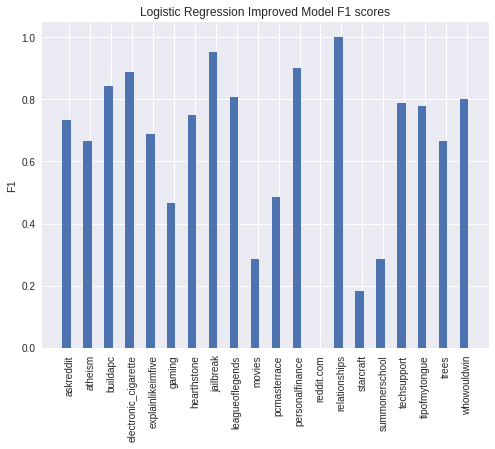

In [0]:
precision, reacall, fscore, support = score(q2_prediction,test_labels)

bars = np.arange(len(q2_pipeline_model.classes_))
classes = q2_pipeline_model.classes_
width=.4
fig, ax=plt.subplots(1,1,figsize=(8,6))
rects1 = ax.bar(bars, fscore, width)

ax.set_ylabel('F1')
ax.set_title('Logistic Regression Improved Model F1 scores')
ax.set_xticks(bars+width/3)
plt.xticks(rotation='vertical')
ax.set_xticklabels(classes)

plt.show()

# fig.savefig('fscores_barplot.png', format='png', dpi=320, bbox_inches='tight')

Confusion matrix, without normalization


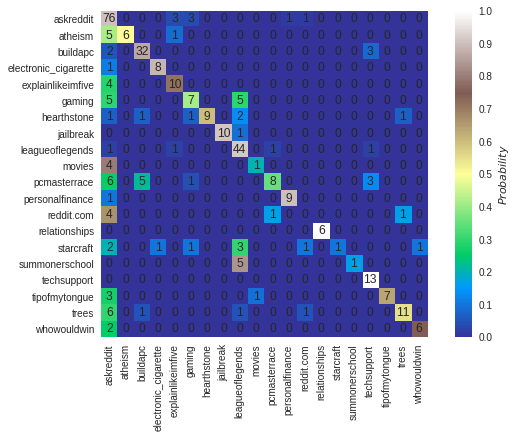

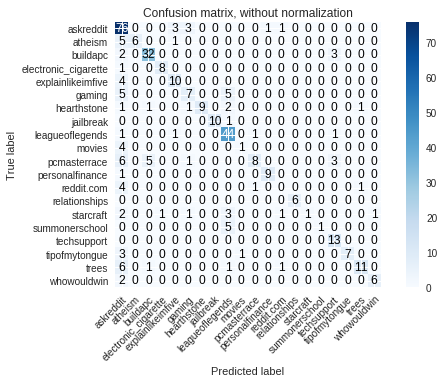

In [0]:
plot_conf_matrix(test_labels,q2_prediction, q2_pipeline_model.classes_, title= 'Confusion Matrix')
plot_confusion_matrix(test_labels, q2_prediction, classes=q2_pipeline_model.classes_,title='Confusion matrix, without normalization')

## Error Analysis
* Manually examine the examples that your algorithm made prediction errors on. 
* See if you spot any systematic trend in what type of examples it is making errors on. 
* You will report on and summarize these findings

Basically found that if a reference to any of the other 

In [0]:
print(train_threads[train_threads.subreddit=='starcraft'].iloc[0].title)
train_threads[train_threads.subreddit=='starcraft'].iloc[0].posts



remember moletrap?


[{'annotations': [{'annotator': '343090f214e68ce7f8a0c4111d6022ec',
    'link_to_post': 'none',
    'main_type': 'question'},
   {'annotator': '440ce79c0e6e377d44b1f9c585154a1f',
    'link_to_post': 'none',
    'main_type': 'question'},
   {'annotator': 'a7fed70cba60eca27950350c2173aaee',
    'link_to_post': 'none',
    'main_type': 'announcement'}],
  'author': 'PreyMonkie',
  'body': "he's on the lol stream now. it seems things have gone downhill for him since he stopped working for gom. he looks like a hobo now.",
  'id': 't3_uu80n',
  'is_first_post': True,
  'majority_link': 'none',
  'majority_type': 'question',
  'url': 'https://www.reddit.com/r/starcraft/comments/uu80n/remember_moletrap/'},
 {'annotations': [{'annotator': '343090f214e68ce7f8a0c4111d6022ec',
    'link_to_post': 't3_uu80n',
    'main_type': 'negativereaction'},
   {'annotator': '440ce79c0e6e377d44b1f9c585154a1f',
    'link_to_post': 't3_uu80n',
    'main_type': 'question'},
   {'annotator': 'a7fed70cba60eca279503

## Feature Analysis
Inspired by the error analysis, engineer two new features you develop to try to improve
the effectiveness. Ideas include:
* Length of posts, lengths of threads, etc…
* TF-IDF values computed from the full Reddit dataset (or larger external data)
* Word embedding features
* Tokenizer modifications (stop word handling, etc…)

Add your feature to the model and retrain. The new features does not have to improve effectiveness

For both (i) and (ii), include in your report 
1. changes to the model and how they were developed. 
2. report the results (same as Q1) on the test data. The final model is expected to outperform the LR TF-IDF baseline.

In [0]:

def create_features_frame(subreddit_file):
  
  posts = list()

  # If the dataset is too large, you can load a subset of the posts.
  post_limit = 100000000
  # Construct a dataframe, by opening the JSON file line-by-line
  with open(subreddit_file) as jsonfile:
    for i, line in enumerate(jsonfile):
      thread = json.loads(line)
      
      if (len(posts) > post_limit):
        break
      #first_post = True
      
      #lent = len(thread['posts'])
      count = 0
      avg_body_length=0.0
      total_comments = 0
      sub=''
      title=''
      url=''
      id_=''
      author=''
      body=''
      body_length=0
      post_depth=0
      majority_type=''
      
      for post in thread['posts']:
        
        
        total_comments = len(thread['posts'])     
        sub =thread['subreddit']
        title = thread['title']
        url = thread['url']
        id_ += " | " +post.get('id',"")
        author+= " | " + post.get('author', "")
        body+=" | " +post.get('body', "")
        avg_length = avg_body_length        
        body_length = len(body)
        majority_type += " | " + post.get('majority_type',"")
      
      avg_body_length = body_length/total_comments      

      posts.append((sub, title, url,id_, author, body,
                         body_length,majority_type
                          ,total_comments,(body_length/total_comments) ) )
  labels = ['subreddit', 'title', 'url', 'id', 'author', 'body', 'body_length','majority_type', 'post_length', 'avg_length']
  return(pd.DataFrame(posts, columns=labels))




In [0]:
train_threads_frame2 = create_features_frame(subreddit_train)
test_threads_frame2 = create_features_frame(subreddit_test)

In [0]:
train_threads_frame2.head()

,subreddit,title,url,id,author,body,body_length,majority_type,post_length,avg_length
0,relationships,How do I [23F] communicate with my self-center...,https://www.reddit.com/r/relationships/comment...,| t1_covzqua | t1_cow04yo | t1_cow4211 | t1_c...,| Pouritdownmythroat | WhyFrankWhy | Pouritdo...,| I think everyone has that one friend who lo...,2532,| answer | | agreement | appreciation | answ...,7,361.714286
1,summonerschool,What Cherry switch do you recommend for League...,https://www.reddit.com/r/summonerschool/commen...,| t3_2w8jon | t1_cooiwv5 | t1_coojoh9 | t1_co...,| | | ThisGermanGuy | shaunrnm | Sub_Salac ...,| I not 100% sure this is the right place to ...,3374,| question | answer | answer | answer | answe...,8,421.750000
2,askreddit,Where do memes go when they die?,https://www.reddit.com/r/AskReddit/comments/4d...,| t3_4dr951 | t1_d1tjpa2 | t1_d1tjolo | t1_d1...,| Leisure321 | Zeolance | | Buttersgoo23 | q...,| | Facebook | | 9gag | Memes never truly d...,156,| question | answer | answer | answer | answe...,10,15.600000
3,trees,Some weird long term affects??,https://www.reddit.com/r/trees/comments/1h300m...,| t1_caqbp3q | t1_caqbzo7 | t1_caqcfm5,| refugee4chan | donquixote6179 | ThatStonedA...,| It's called 'forgetting things'. | Dude i d...,297,| answer | answer | agreement,3,99.000000
4,buildapc,Simple question: If I install Windows to a sta...,https://www.reddit.com/r/buildapc/comments/jhb...,| t3_jhbqc | t1_c2c566a | t1_c2c3s12 | t1_c2c...,| catalyzeme | uses | rvabdn | greg2709 | spy...,| How would I do this? I am looking to wait a...,1459,| question | answer | answer | answer | answer,5,291.800000


### Re-fit and predict model
After analysis, decided to add the following features:
- majority type
- body length
- post length
- average length

#### Pipe

In [0]:
## Wrapper to return the dataframe column incase of non-string values 
def get_body_length(df):
  return df['body_length'].values.reshape(len(df),1)
call_body_length = FunctionTransformer(get_body_length, validate=False)

def get_post_length(df):
  return df['post_length'].values.reshape(len(df),1)
call_post_length = FunctionTransformer(get_post_length, validate=False)

def get_avg_length(df):
  return df['body_length'].values.reshape(len(df),1)
call_avg_length = FunctionTransformer(get_avg_length, validate=False)


In [0]:


q2_majority_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
              
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False, max_features=5000, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
           
            ('majority_type', Pipeline([
              ('selector', ItemSelector(key='majority_type')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
        
        ])
        ),
    ])


   



In [0]:
q2_train_features_1 = q2_majority_pipeline.fit_transform(train_threads_frame2)
q2_test_features_1 = q2_majority_pipeline.transform(test_threads_frame2)


q2_lr_1 = LogisticRegression(C=10000, solver = 'newton-cg', multi_class = 'multinomial')
q2_lr_model_1 = q2_lr_1.fit(q2_train_features_1,train_labels)
q2_lr_predict_1 = q2_lr_1.predict(q2_test_features_1)

evaluation_summary("LR Majority Type Feature", q2_lr_predict_1, test_labels)                                


Evaluation for: LR Majority Type Feature
Classifier 'LR Majority Type Feature' has Acc=0.729 P=0.626 R=0.783 F1=0.655
                      precision    recall  f1-score   support

           askreddit      0.929     0.645     0.761       121
             atheism      0.667     1.000     0.800         8
            buildapc      0.811     0.811     0.811        37
electronic_cigarette      0.778     0.778     0.778         9
   explainlikeimfive      0.714     0.909     0.800        11
              gaming      0.529     0.529     0.529        17
         hearthstone      0.600     1.000     0.750         9
           jailbreak      0.818     1.000     0.900         9
     leagueoflegends      0.917     0.710     0.800        62
              movies      0.200     0.500     0.286         2
        pcmasterrace      0.304     0.778     0.438         9
     personalfinance      1.000     0.833     0.909        12
          reddit.com      0.000     0.000     0.000         2
       relati

In [0]:
q2_length_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
              
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False, max_features=5000, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
            ('body_length', call_body_length),
            ('avg_length', call_avg_length),
            ('post_length', call_post_length),             
        ])
        ),
    ])


   



In [0]:
q2_train_features_2 = q2_length_pipeline.fit_transform(train_threads_frame2)
q2_test_features_2 = q2_length_pipeline.transform(test_threads_frame2)


q2_lr_2 = LogisticRegression(C=10000, solver = 'newton-cg', multi_class = 'multinomial')
q2_lr_model_2 = q2_lr_2.fit(q2_train_features_2,train_labels)
q2_lr_predict_2 = q2_lr_2.predict(q2_test_features_2)

In [0]:
evaluation_summary("LR Lengths Features", q2_lr_predict_2, test_labels)                                


Evaluation for: LR Lengths Features
Classifier 'LR Lengths Features' has Acc=0.775 P=0.688 R=0.797 F1=0.710
                      precision    recall  f1-score   support

           askreddit      0.940     0.687     0.794       115
             atheism      0.667     1.000     0.800         8
            buildapc      0.892     0.868     0.880        38
electronic_cigarette      0.889     0.800     0.842        10
   explainlikeimfive      0.929     0.812     0.867        16
              gaming      0.412     0.636     0.500        11
         hearthstone      0.667     1.000     0.800        10
           jailbreak      0.909     1.000     0.952        10
     leagueoflegends      0.938     0.763     0.841        59
              movies      0.400     0.667     0.500         3
        pcmasterrace      0.348     0.800     0.485        10
     personalfinance      1.000     1.000     1.000        10
          reddit.com      0.000     0.000     0.000         2
       relationships   

In [0]:


q2_final_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
              
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False, max_features=5000, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
           
            ('majority_type', Pipeline([
              ('selector', ItemSelector(key='majority_type')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),

            ('body_length', call_body_length),
            ('avg_length', call_avg_length),
            ('post_length', call_post_length),             
        ])
        ),
    ])


   



In [0]:
q2_train_features = q2_final_pipeline.fit_transform(train_threads_frame2)
q2_test_features = q2_final_pipeline.transform(test_threads_frame2)


q2_lr = LogisticRegression(C=10000, solver = 'newton-cg', multi_class = 'multinomial')
q2_lr_model = q2_lr.fit(q2_train_features,train_labels)
q2_lr_predict = q2_lr.predict(q2_test_features)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [0]:
evaluation_summary("LR Combined Features", q2_lr_predict, test_labels)                                


Evaluation for: LR Combined Features
Classifier 'LR Combined Features' has Acc=0.740 P=0.644 R=0.803 F1=0.667
                      precision    recall  f1-score   support

           askreddit      0.940     0.693     0.798       114
             atheism      0.583     1.000     0.737         7
            buildapc      0.811     0.811     0.811        37
electronic_cigarette      0.778     0.778     0.778         9
   explainlikeimfive      0.929     0.812     0.867        16
              gaming      0.471     0.571     0.516        14
         hearthstone      0.600     0.900     0.720        10
           jailbreak      0.818     1.000     0.900         9
     leagueoflegends      0.917     0.688     0.786        64
              movies      0.200     1.000     0.333         1
        pcmasterrace      0.304     0.875     0.452         8
     personalfinance      1.000     0.909     0.952        11
          reddit.com      0.000     0.000     0.000         4
       relationships 

#### Plot results

Confusion matrix, without normalization


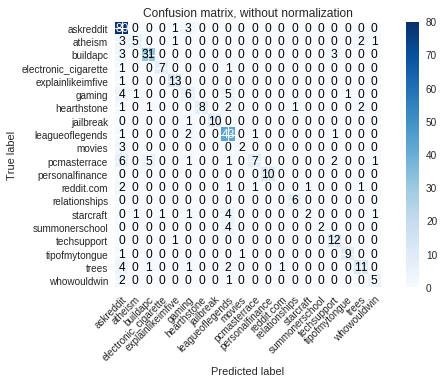

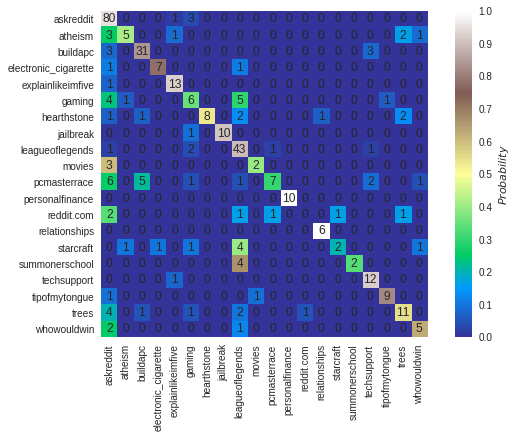

In [0]:

plot_confusion_matrix(test_labels, q2_lr_predict, q2_lr_model.classes_,title='Confusion matrix, without normalization')
plot_conf_matrix(test_labels,q2_lr_predict, q2_lr_model.classes_, title= 'Confusion Matrix')

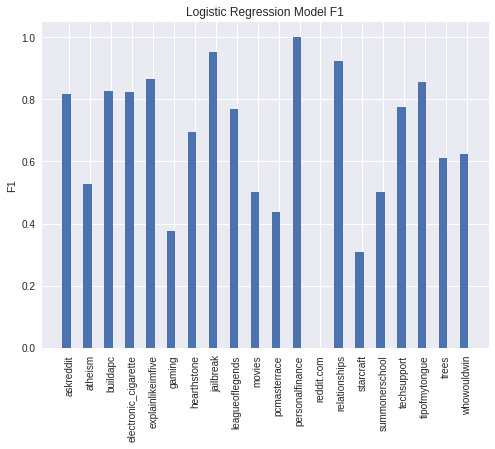

In [0]:
create_plot('Logistic Regression Model F1', q2_lr_model, q2_lr_predict, test_labels)

# Part B: Discourse prediction ##

## Q3

In [0]:
discourse_train = "coursework_discourse_train.json"
discourse_test = "coursework_discourse_test.json"
  
!gsutil cp gs://textasdata/coursework/coursework_discourse_train.json $discourse_train  
!gsutil cp gs://textasdata/coursework/coursework_discourse_test.json  $discourse_test

Copying gs://textasdata/coursework/coursework_discourse_train.json...
\ [1 files][ 60.2 MiB/ 60.2 MiB]                                                
Operation completed over 1 objects/60.2 MiB.                                     
Copying gs://textasdata/coursework/coursework_discourse_test.json...
- [1 files][ 15.1 MiB/ 15.1 MiB]                                                
Operation completed over 1 objects/15.1 MiB.                                     


In [0]:
# The reddit thread structure is nested with posts in a new content.
# This block reads the file as json and creates a new data frame.

def load_posts(file):
  # A temporary variable to store the list of post content.
  posts_tmp = list()

  with open(file) as jsonfile:
    for i, line in enumerate(jsonfile):
     # if (i > 2): break
      thread = json.loads(line)
      for post in thread['posts']:
        # NOTE: This could be changed to use additional features from the post or thread.
        # DO NOT change the labels for the test set.
        posts_tmp.append((thread['subreddit'], thread['title'], thread['url'],
                        post['id'], post.get('author', ""), post.get('body', ""), post.get("majority_link", ""), 
                        post.get('post_depth', 0), post.get('majority_type', ""), # discourse type label 
                        post.get('in_reply_to', "") ))

# Create the posts data frame.  
  labels = ['subreddit', 'title', 'url', 'id', 'author', 'body', 'majority_link', 
          'post_depth', 'discourse_type', 'in_reply_to']
  return pd.DataFrame(posts_tmp, columns=labels)

In [0]:
train_posts = load_posts(discourse_train)
# Filter out empty labels
train_posts = train_posts[train_posts['discourse_type'] != ""]
print("Num posts: ", train_posts.size)
train_posts.head()


Num posts:  792670


,subreddit,title,url,id,author,body,majority_link,post_depth,discourse_type,in_reply_to
0,worldofpvp,Help me decide my new PvP main,https://www.reddit.com/r/worldofpvp/comments/2...,t3_2v0anq,TyrickEU,"Hi. \nAs a raider previously, i had no problem...",none,0,question,
1,worldofpvp,Help me decide my new PvP main,https://www.reddit.com/r/worldofpvp/comments/2...,t1_codb2p9,vurt,[deleted] \n ^^^^^^^^^^^^^^^^0.5422 \n > [Wha...,t3_2v0anq,1,answer,t3_2v0anq
2,worldofpvp,Help me decide my new PvP main,https://www.reddit.com/r/worldofpvp/comments/2...,t1_codg0we,OptimusNice,This goes mostly for 3v3 since that seems to b...,t3_2v0anq,1,answer,t3_2v0anq
3,worldofpvp,Help me decide my new PvP main,https://www.reddit.com/r/worldofpvp/comments/2...,t1_coeatsq,,"Rets are in a good position right now, althoug...",t3_2v0anq,1,answer,t3_2v0anq
4,worldofpvp,Help me decide my new PvP main,https://www.reddit.com/r/worldofpvp/comments/2...,t1_codbyit,Rageinjector,Druid are the best pvp healer atm and are grea...,t3_2v0anq,1,answer,t3_2v0anq


The label for the post we will be predicting is in the discourse_type column.

In [0]:
test_posts = load_posts(discourse_test)
# Filter out empty labels
test_posts = test_posts[test_posts['discourse_type'] != ""]
print("Num posts: ", test_posts.size)


Num posts:  198120


In [0]:
train_labels_p2 = train_posts['discourse_type']
test_labels_p2 = test_posts['discourse_type']

Examine the distribution over labels on the training data.

In [0]:
discourse_counts = train_labels_p2.value_counts()
print(discourse_counts.describe())

top_discourse = discourse_counts.nlargest(200)
print(top_discourse)
top_discourse = top_discourse.index.tolist()
print(top_discourse)

count       10.000000
mean      7926.700000
std       9664.321866
min       1266.000000
25%       1671.500000
50%       3235.500000
75%      11919.750000
max      31419.000000
Name: discourse_type, dtype: float64
answer              31419
elaboration         14775
question            13610
appreciation         6849
agreement            3868
disagreement         2603
humor                1787
other                1633
announcement         1457
negativereaction     1266
Name: discourse_type, dtype: int64
['answer', 'elaboration', 'question', 'appreciation', 'agreement', 'disagreement', 'humor', 'other', 'announcement', 'negativereaction']


### Pipeline

In [0]:
disc_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
              
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False, max_features=5000, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
             
        ])
        ),
       ('classifier', LogisticRegression(C=10000, solver = 'saga', multi_class = 'multinomial'))
    ])

disc_pipe_model = disc_pipeline.fit(train_posts, train_labels_p2)
prediction_disc = disc_pipeline.predict(test_posts)
   


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [0]:
evaluation_summary("LR TFIDF Discourse", prediction_disc, test_labels_p2)

Evaluation for: LR TFIDF Discourse
Classifier 'LR TFIDF Discourse' has Acc=0.423 P=0.243 R=0.274 F1=0.253
                  precision    recall  f1-score   support

       agreement      0.210     0.267     0.235       748
    announcement      0.112     0.155     0.130       264
          answer      0.592     0.515     0.551      9124
    appreciation      0.547     0.602     0.573      1561
    disagreement      0.059     0.117     0.079       325
     elaboration      0.240     0.263     0.251      3304
           humor      0.053     0.129     0.075       186
negativereaction      0.068     0.143     0.093       147
           other      0.109     0.157     0.129       261
        question      0.440     0.387     0.412      3892

       micro avg      0.423     0.423     0.423     19812
       macro avg      0.243     0.274     0.253     19812
    weighted avg      0.455     0.423     0.437     19812


Confusion matrix:
 [[ 200    5  386   56   21  147    7    7   11  111]
 [   5

#### Plot results

Confusion matrix, without normalization


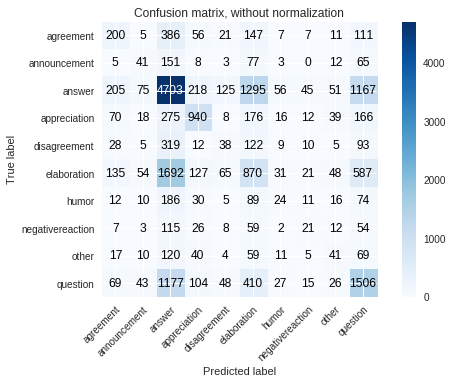

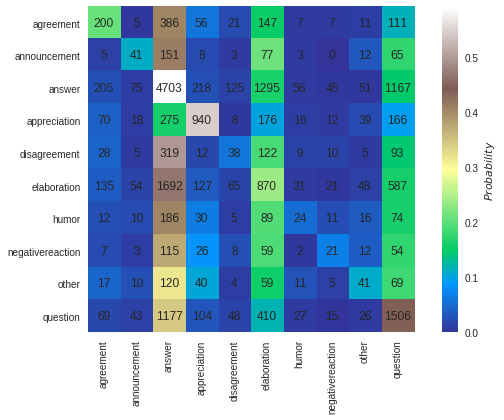

In [0]:

plot_confusion_matrix(test_labels_p2, prediction_disc, classes=disc_pipe_model.classes_,title='Confusion matrix, without normalization')

plot_conf_matrix(test_labels_p2,prediction_disc, disc_pipe_model.classes_, title= 'Confusion Matrix')

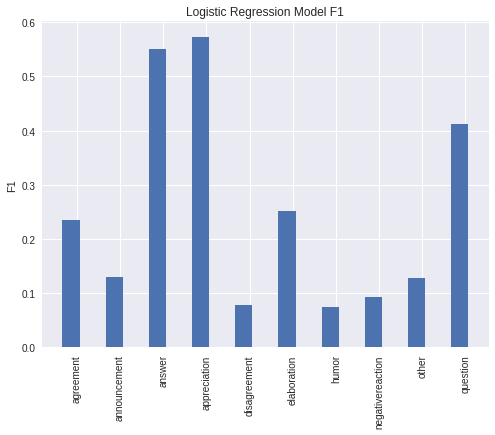

In [0]:
create_plot('Logistic Regression Model F1', disc_pipe_model, prediction_disc, test_labels_p2)


### GridSearch

### Re-fit and predict

## Q4



In [0]:
# The reddit thread structure is nested with posts in a new content.
# This block reads the file as json and creates a new data frame.


def load_features(file):
  # A temporary variable to store the list of post content.
  posts_tmp = list()

  with open(file) as jsonfile:
    for i, line in enumerate(jsonfile):
     # if (i > 2): break
      thread = json.loads(line)
      
      count = 0
      avg_body_length=0.0
      post_length = 0
      body_length=0
      qpunc = ''
      total_comments=0
      
      for post in thread['posts']:
          
        body = post.get('body', "")
        post_length += len(body)
        total_comments +=1
        count+=1

      #avg_body_length = total_comments/count
      firstPost = True
      
      for post in thread['posts']:
        body = post.get('body', "")
        body_length = len(body)

        post_depth =''
          
        ## Post depth bins
        if post.get('post_depth',"") == 1:
          post_depth='group A'
        elif post.get('post_depth',"")==2:
          post_depth='group B'
        elif post.get('post_depth',"")==3:
          post_depth='group B'
        elif post.get('post_depth',"")==4:
          post_depth='group C'
        else:
          post_depth='group C'

                
    
        if post.get('is_self_post',"")==1.0:
          self_post= 'Yes'
        else:
          self_post = 'No'
             
        firstPost=False
        ## lengths
        length_group=''
        if(body_length < 10):
          length_group = 'Group A'
        elif(body_length > 10 & body_length< 50):
          length_group = 'Group B'
        elif(body_length > 50 & body_length< 200):
          length_group = 'Group C'
        elif(body_length > 200 & body_length< 500):
          length_group = 'Group D'
        elif(body_length > 500 & body_length< 1000):
          length_group = 'Group E'
        elif(body_length > 1000 & body_length< 2000):
          length_group = 'Group F'
        elif(body_length > 2000 & body_length< 3000):
          length_group = 'Group G'
        else:
          length_group = 'Group H'
        
        #self author
        same_auth=0
        if( thread['is_self_post']==None):
          thread['is_self_post']=0
        thread['top_author']=thread['posts'][0].get('author',"")
        
        if(thread['top_author']==post.get('author',"")):
          same_auth=1
        
        
        ##comments
        total_comments = len(thread['posts'])
        sub_auth = thread['subreddit'] + "," +  post.get('author', "")
        posts_tmp.append((self_post,thread['subreddit'], thread['title'], thread['url'],
                        post['id'], post.get('author', ""),body, post.get("majority_link", ""), 
                        post.get('post_depth', 0), post.get('majority_type', ""),  
                        post.get('in_reply_to', ""), post_depth, total_comments, length_group, sub_auth, same_auth))

# Create the posts data frame.  
  labels = ['selfpost','subreddit', 'title', 'url', 'id', 'author', 'body', 'majority_link', 
          'post_depth', 'discourse_type', 'in_reply_to', 'post_depthcat', 'total_comments','body_length','sub_auth','same_auth']
  return pd.DataFrame(posts_tmp, columns=labels)

In [0]:
train_posts_q4 = load_features(discourse_train)
# Filter out empty labels
train_posts_q4 = train_posts_q4[train_posts_q4['discourse_type'] != ""]
print("Num posts: ", train_posts_q4.shape)

test_posts_q4 = load_features(discourse_test)
# Filter out empty labels
test_posts_q4 = test_posts_q4[test_posts_q4['discourse_type'] != ""]
print("Num posts: ", test_posts_q4.shape)


Num posts:  (79267, 16)
Num posts:  (19812, 16)


In [0]:
train_posts.head()


,selfpost,subreddit,title,url,id,author,body,majority_link,post_depth,discourse_type,in_reply_to,post_depthcat,total_comments,body_length,sub_auth,same_auth
0,No,worldofpvp,Help me decide my new PvP main,https://www.reddit.com/r/worldofpvp/comments/2...,t3_2v0anq,TyrickEU,"Hi. \nAs a raider previously, i had no problem...",none,0,question,,group CS,7,Group B,"worldofpvp,TyrickEU",1
1,No,worldofpvp,Help me decide my new PvP main,https://www.reddit.com/r/worldofpvp/comments/2...,t1_codb2p9,vurt,[deleted] \n ^^^^^^^^^^^^^^^^0.5422 \n > [Wha...,t3_2v0anq,1,answer,t3_2v0anq,group A,7,Group B,"worldofpvp,vurt",0
2,No,worldofpvp,Help me decide my new PvP main,https://www.reddit.com/r/worldofpvp/comments/2...,t1_codg0we,OptimusNice,This goes mostly for 3v3 since that seems to b...,t3_2v0anq,1,answer,t3_2v0anq,group A,7,Group B,"worldofpvp,OptimusNice",0
3,No,worldofpvp,Help me decide my new PvP main,https://www.reddit.com/r/worldofpvp/comments/2...,t1_coeatsq,,"Rets are in a good position right now, althoug...",t3_2v0anq,1,answer,t3_2v0anq,group A,7,Group B,"worldofpvp,",0
4,No,worldofpvp,Help me decide my new PvP main,https://www.reddit.com/r/worldofpvp/comments/2...,t1_codbyit,Rageinjector,Druid are the best pvp healer atm and are grea...,t3_2v0anq,1,answer,t3_2v0anq,group A,7,Group B,"worldofpvp,Rageinjector",0


In [0]:
test_posts.head()

,subreddit,title,url,id,author,body,majority_link,post_depth,discourse_type,in_reply_to
0,photography,Is it against the law to stop on the side of a...,https://www.reddit.com/r/photography/comments/...,t3_1ds5ds,sobeisforlovers,Edit: I'm in the Oklahoma City and Tulsa Oklah...,none,0,question,
1,photography,Is it against the law to stop on the side of a...,https://www.reddit.com/r/photography/comments/...,t1_c9tbz9b,KevinAndEarth,are you in the USA? i would say that unless t...,t3_1ds5ds,1,question,t3_1ds5ds
2,photography,Is it against the law to stop on the side of a...,https://www.reddit.com/r/photography/comments/...,t1_c9tcqh8,,[deleted],t1_c9tbz9b,2,answer,t1_c9tbz9b
3,photography,Is it against the law to stop on the side of a...,https://www.reddit.com/r/photography/comments/...,t1_c9thky3,EnglishTraitor,Great info! It shows that stopping on a highwa...,t1_c9tcqh8,3,appreciation,t1_c9tcqh8
4,photography,Is it against the law to stop on the side of a...,https://www.reddit.com/r/photography/comments/...,t1_c9twaqh,pixelmonger,"Lately, it's been my experience that taking ne...",,2,elaboration,t1_c9tbz9b


In [0]:
# print(train_threads[train_threads.subreddit=='starcraft'].iloc[:10].title)
# train_threads[train_threads.subreddit=='starcraft'].iloc[1].posts

## Adding features

In [0]:
# This is the tokenizer that removes punctuation
def normalize2(tokens):
  normalized_tokens = list()
  for token in tokens:
    normalized = token.text.lower().strip()
    if ((token.is_alpha or token.is_digit or token.is_punct )):
      normalized_tokens.append(normalized)
  return normalized_tokens

#@Tokenize and normalize
def punctuation_tokenize_normalize(string):
  return normalize2(spacy_tokenize(string))

## Wrapper to return the dataframe column incase of non-string values 

# Thread features
def get_comments(df):
  return df['total_comments'].values.reshape(len(df),1)
call_total_comments = FunctionTransformer(get_comments, validate=False)

# Author feature
def get_self_author(df):
  return df['same_auth'].values.reshape(len(df),1)
call_self_author = FunctionTransformer(get_self_author, validate=False)

# Structure feature
def get_body_length(df):
  return df['body_length'].values.reshape(len(df),1)
call_body_length = FunctionTransformer(get_body_length, validate=False)


In [0]:
# explanation of tokenizer
string = 'No! this game, so ridiculous!'
# tokenizer that removes punctuation
print(tokenize_normalize(string))

#tokenizer that keeps punctuation
print(punctuation_tokenize_normalize(string))

['no', 'this', 'game', 'so', 'ridiculous']
['no', '!', 'this', 'game', ',', 'so', 'ridiculous', '!']


### Community

In [0]:
community_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
              
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False, max_features=5000, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
           
            #Community
            ('subreddit', Pipeline([
              ('selector', ItemSelector(key='subreddit')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
             
        ])
        ),
       ('classifier', LogisticRegression(C=10000, solver = 'saga', multi_class = 'multinomial'))
    ])
   
community_pipeline.fit(train_posts_q4, train_labels_p2)
community_prediction = community_pipeline.predict(test_posts_q4)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: LR Baseline with Author feature
Classifier 'LR Baseline with Author feature' has Acc=0.431 P=0.249 R=0.288 F1=0.261
                  precision    recall  f1-score   support

       agreement      0.215     0.274     0.241       745
    announcement      0.121     0.155     0.136       283
          answer      0.606     0.518     0.558      9289
    appreciation      0.559     0.610     0.583      1578
    disagreement      0.076     0.147     0.101       333
     elaboration      0.237     0.264     0.250      3263
           humor      0.046     0.130     0.068       161
negativereaction      0.075     0.169     0.104       136
           other      0.114     0.213     0.149       202
        question      0.446     0.399     0.421      3822

       micro avg      0.431     0.431     0.431     19812
       macro avg      0.249     0.288     0.261     19812
    weighted avg      0.467     0.431     0.446     19812


Confusion matrix:
 [[ 204    4  379   60   21  156  

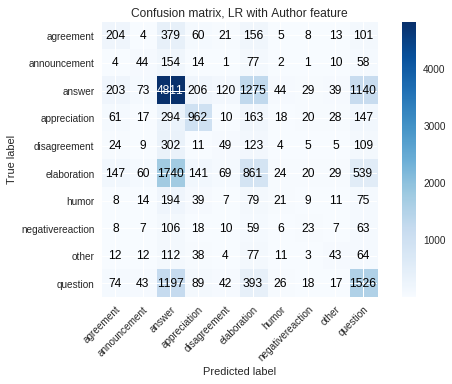

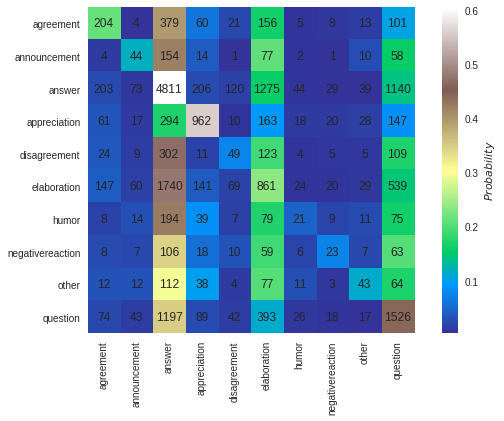

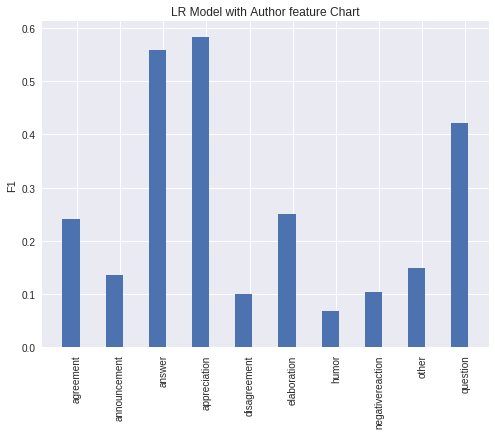

In [0]:
evaluation_summary("LR Baseline with Author feature", community_prediction, test_labels_p2)      

plot_confusion_matrix(test_labels_p2, community_prediction, classes=community_pipeline.classes_,title='Confusion matrix, LR with Author feature')
plot_conf_matrix(test_labels_p2,community_prediction, community_pipeline.classes_, title= 'Confusion Matrix')

create_plot('LR Model with Author feature Chart', community_pipeline, community_prediction, test_labels_p2)


### Structure

In [0]:
structure_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
              
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False, max_features=5000, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
           
              
            #structure
            ('post_depthcat', Pipeline([
              ('selector', ItemSelector(key='post_depthcat')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
            ('body_length', Pipeline([
              ('selector', ItemSelector(key='body_length')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),

             
        ])
        ),
       ('classifier', LogisticRegression(C=10000, solver = 'saga', multi_class = 'multinomial'))
    ])


   
structure_pipeline.fit(train_posts_q4, train_labels_p2)
structure_prediction = structure_pipeline.predict(test_posts_q4)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: LR Baseline with structure feature
Classifier 'LR Baseline with structure feature' has Acc=0.520 P=0.320 R=0.352 F1=0.329
                  precision    recall  f1-score   support

       agreement      0.251     0.315     0.280       758
    announcement      0.441     0.426     0.433       378
          answer      0.723     0.640     0.679      8964
    appreciation      0.559     0.629     0.592      1529
    disagreement      0.129     0.203     0.158       408
     elaboration      0.325     0.349     0.337      3382
           humor      0.048     0.133     0.071       165
negativereaction      0.072     0.176     0.102       125
           other      0.109     0.169     0.133       242
        question      0.539     0.478     0.506      3861

       micro avg      0.520     0.520     0.520     19812
       macro avg      0.320     0.352     0.329     19812
    weighted avg      0.554     0.520     0.534     19812


Confusion matrix:
 [[ 239    5  256   63   32 

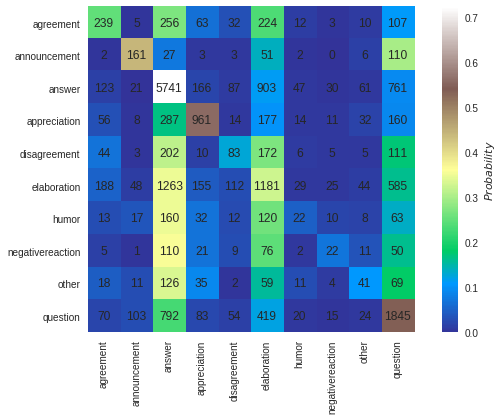

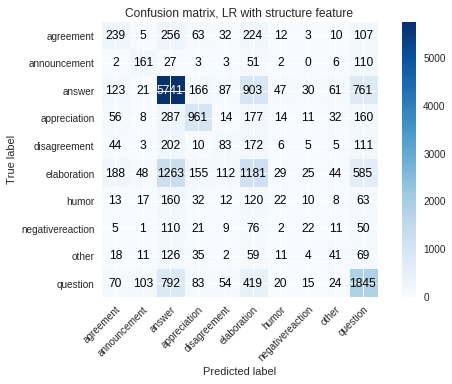

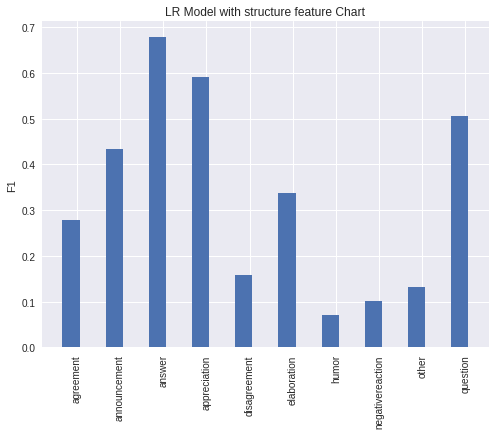

In [0]:
evaluation_summary("LR Baseline with structure feature", structure_prediction, test_labels_p2)      
plot_conf_matrix(test_labels_p2,structure_prediction, structure_pipeline.classes_, title= 'Confusion Matrix')
plot_confusion_matrix(test_labels_p2, structure_prediction, classes=structure_pipeline.classes_,title='Confusion matrix, LR with structure feature')
create_plot('LR Model with structure feature Chart', structure_pipeline, structure_prediction, test_labels_p2)


### Metadata

In [0]:


metadata_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
              
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False, max_features=5000, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
           
           
              
            #Metadata 
            ('sub_auth', Pipeline([
              ('selector', ItemSelector(key='sub_auth')),
              ('tfidf', TfidfVectorizer(tokenizer=punctuation_tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),

             
        ])
        ),
       ('classifier', LogisticRegression(C=10000, solver = 'saga', multi_class = 'multinomial'))
    ])
   
metadata_pipe_model = metadata_pipeline.fit(train_posts_q4, train_labels_p2)
metadata_prediction = metadata_pipe_model.predict(test_posts_q4)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: LR Baseline with metadata feature
Classifier 'LR Baseline with metadata feature' has Acc=0.425 P=0.245 R=0.283 F1=0.257
                  precision    recall  f1-score   support

       agreement      0.208     0.265     0.233       746
    announcement      0.112     0.169     0.135       242
          answer      0.598     0.511     0.551      9291
    appreciation      0.556     0.602     0.578      1588
    disagreement      0.069     0.132     0.090       334
     elaboration      0.235     0.266     0.250      3212
           humor      0.053     0.136     0.076       176
negativereaction      0.075     0.177     0.105       130
           other      0.114     0.185     0.141       232
        question      0.432     0.383     0.406      3861

       micro avg      0.425     0.425     0.425     19812
       macro avg      0.245     0.283     0.257     19812
    weighted avg      0.460     0.425     0.439     19812


Confusion matrix:
 [[ 198    2  383   56   25  1

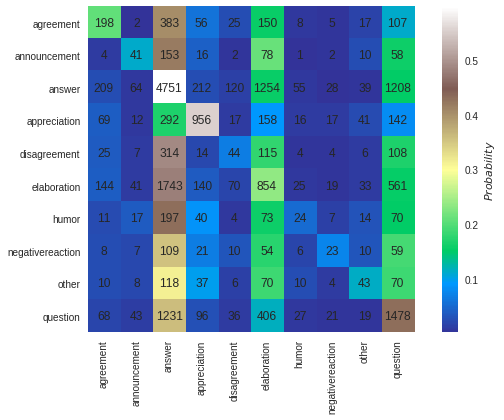

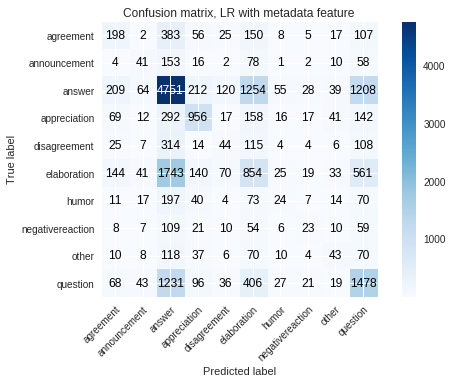

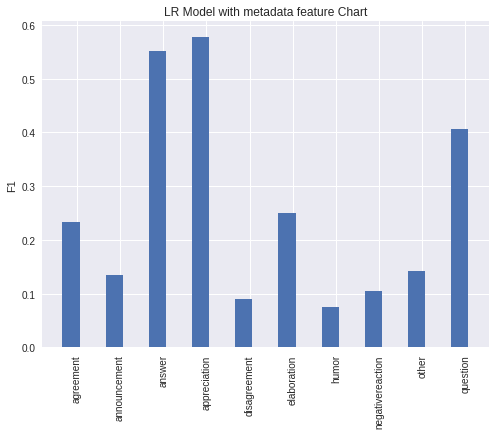

In [0]:
evaluation_summary("LR Baseline with metadata feature", metadata_prediction, test_labels_p2)      
plot_conf_matrix(test_labels_p2,metadata_prediction, metadata_pipe_model.classes_, title= 'Confusion Matrix')
plot_confusion_matrix(test_labels_p2, metadata_prediction, classes=metadata_pipe_model.classes_,title='Confusion matrix, LR with metadata feature')
create_plot('LR Model with metadata feature Chart', metadata_pipe_model, metadata_prediction, test_labels_p2)


### Content + Punctuation

In [0]:
cp_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
              
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False, max_features=5000, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            #Content+punctuation 
            ('body_punc', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=punctuation_tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
             
        ])
        ),
       ('classifier', LogisticRegression(C=10000, solver = 'saga', multi_class = 'multinomial'))
    ])

#one line wrapper that is vectorizer

   
cp_model = cp_pipeline.fit(train_posts_q4, train_labels_p2)
cp_prediction = cp_pipeline.predict(test_posts_q4)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: LR Baseline with  content+punctuation feature
Classifier 'LR Baseline with  content+punctuation feature' has Acc=0.502 P=0.291 R=0.345 F1=0.307
                  precision    recall  f1-score   support

       agreement      0.245     0.346     0.287       674
    announcement      0.126     0.178     0.147       259
          answer      0.654     0.543     0.593      9573
    appreciation      0.584     0.641     0.611      1567
    disagreement      0.080     0.180     0.110       284
     elaboration      0.281     0.306     0.293      3339
           humor      0.066     0.224     0.102       134
negativereaction      0.094     0.200     0.128       145
           other      0.117     0.200     0.148       220
        question      0.666     0.631     0.648      3617

       micro avg      0.502     0.502     0.502     19812
       macro avg      0.291     0.345     0.307     19812
    weighted avg      0.545     0.502     0.519     19812


Confusion matrix:
 [[ 23

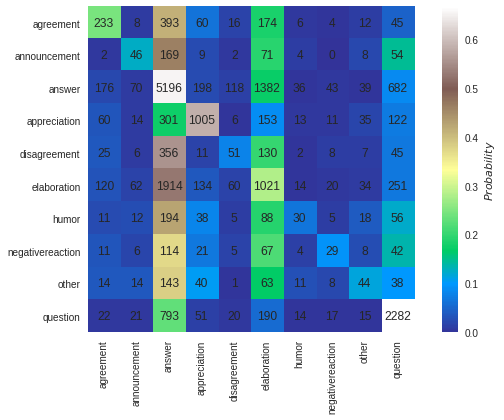

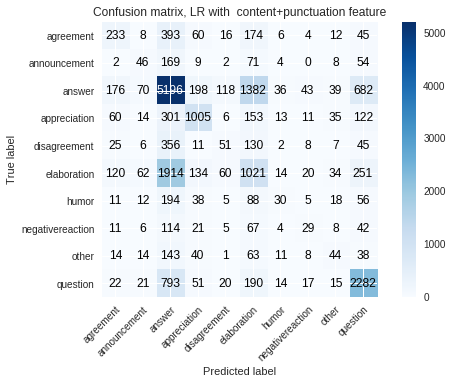

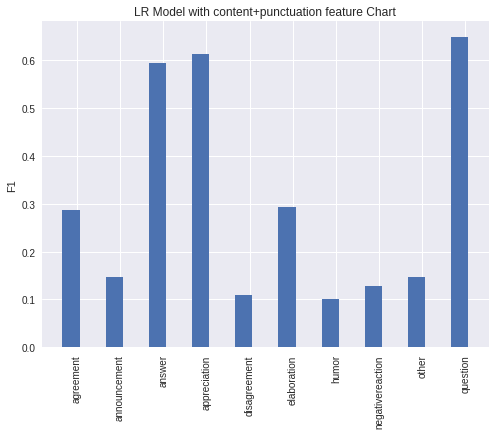

In [0]:
evaluation_summary("LR Baseline with  content+punctuation feature", cp_prediction, test_labels_p2)      
plot_conf_matrix(test_labels_p2,cp_prediction, cp_model.classes_, title= 'Confusion Matrix')
plot_confusion_matrix(test_labels_p2, cp_prediction, classes=cp_model.classes_,title='Confusion matrix, LR with  content+punctuation feature')
create_plot('LR Model with content+punctuation feature Chart', cp_model, cp_prediction, test_labels_p2)


### Author

In [0]:
author_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
              
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False, max_features=5000, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            #same auth 
            ('self_author', call_self_author),
              
              
             
        ])
        ),
       ('classifier', LogisticRegression(C=10000, solver = 'saga', multi_class = 'multinomial'))
    ])


   
author_model = author_pipeline.fit(train_posts_q4, train_labels_p2)
author_prediction = author_pipeline.predict(test_posts_q4)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: LR Baseline with author feature
Classifier 'LR Baseline with author feature' has Acc=0.458 P=0.275 R=0.305 F1=0.284
                  precision    recall  f1-score   support

       agreement      0.211     0.284     0.242       707
    announcement      0.318     0.322     0.320       360
          answer      0.638     0.547     0.589      9258
    appreciation      0.549     0.614     0.579      1538
    disagreement      0.062     0.124     0.083       322
     elaboration      0.242     0.269     0.255      3261
           humor      0.046     0.115     0.066       182
negativereaction      0.062     0.138     0.085       138
           other      0.112     0.175     0.136       240
        question      0.513     0.461     0.486      3806

       micro avg      0.458     0.458     0.458     19812
       macro avg      0.275     0.305     0.284     19812
    weighted avg      0.495     0.458     0.474     19812


Confusion matrix:
 [[ 201    5  394   51   23  150  

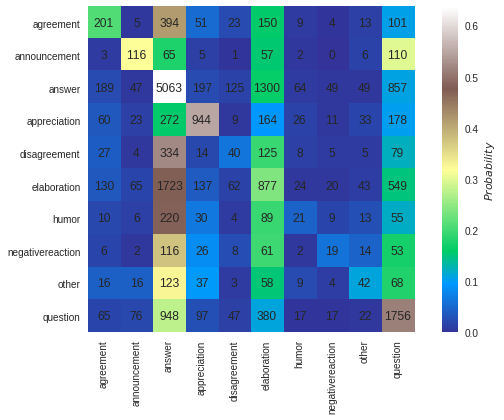

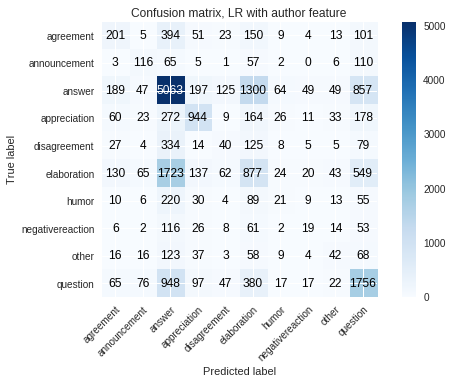

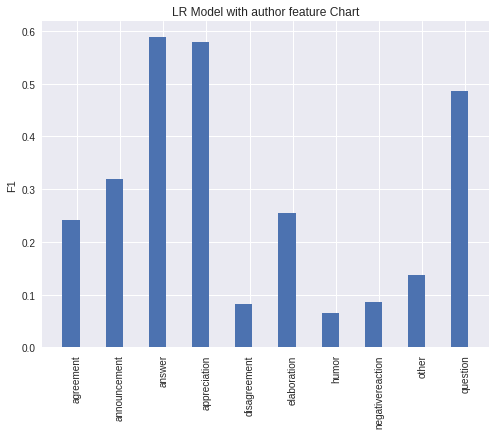

In [0]:
evaluation_summary("LR Baseline with author feature", author_prediction, test_labels_p2)      
plot_conf_matrix(test_labels_p2,author_prediction, author_model.classes_, title= 'Confusion Matrix')
plot_confusion_matrix(test_labels_p2, author_prediction, classes=author_model.classes_,title='Confusion matrix, LR with author feature')
create_plot('LR Model with author feature Chart', author_model, author_prediction, test_labels_p2)


### Total Comments

In [0]:
comments_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
              
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False, max_features=5000, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            #Thread features
            ('Total_comments', call_total_comments),
              
              
             
        ])
        ),
       ('classifier', LogisticRegression(C=10000, solver = 'saga', multi_class = 'multinomial'))
    ])


   
comments_model = comments_pipeline.fit(train_posts_q4, train_labels_p2)
comments_prediction = comments_pipeline.predict(test_posts_q4)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: LR Baseline with total comments feature


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Classifier 'LR Baseline with total comments feature' has Acc=0.516 P=0.231 R=0.463 F1=0.241


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                  precision    recall  f1-score   support

       agreement      0.162     0.537     0.249       287
    announcement      0.000     0.000     0.000         0
          answer      0.845     0.515     0.640     13023
    appreciation      0.585     0.767     0.664      1311
    disagreement      0.003     0.100     0.006        20
     elaboration      0.214     0.325     0.258      2392
           humor      0.007     0.231     0.013        13
negativereaction      0.003     1.000     0.006         1
           other      0.035     0.591     0.065        22
        question      0.455     0.569     0.506      2743

       micro avg      0.516     0.516     0.516     19812
       macro avg      0.231     0.463     0.241     19812
    weighted avg      0.685     0.516     0.569     19812


Confusion matrix:
 [[ 154    0  495   35    2  195    1    0    0   69]
 [   0    0  262    9    0   51    1    0    0   42]
 [  53    0 6706   79    6  626    1    0    1  468]
 [  15

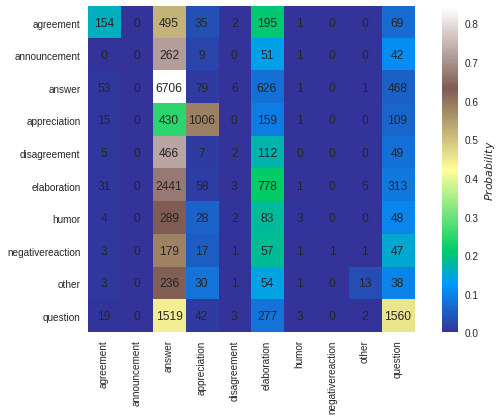

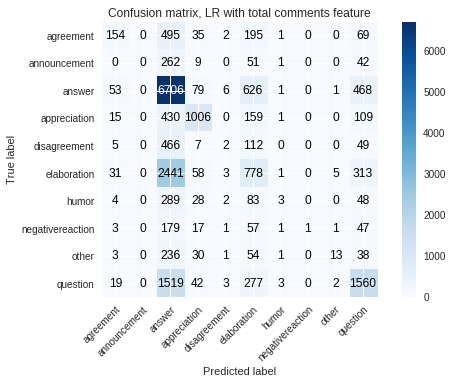

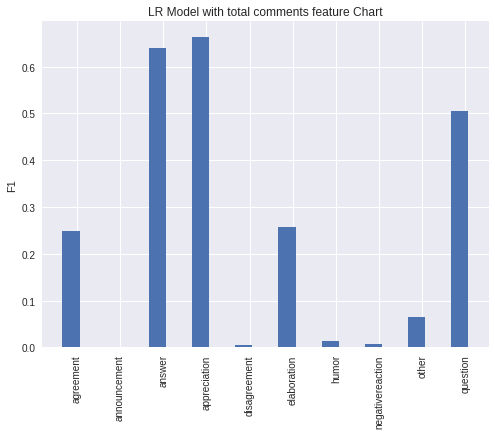

In [0]:
evaluation_summary("LR Baseline with total comments feature", comments_prediction, test_labels_p2)      
plot_conf_matrix(test_labels_p2,comments_prediction, comments_model.classes_, title= 'Confusion Matrix')
plot_confusion_matrix(test_labels_p2, comments_prediction, classes=comments_model.classes_,title='Confusion matrix, LR with total comments feature')
create_plot('LR Model with total comments feature Chart', comments_model, comments_prediction, test_labels_p2)


### Combined Run

In [0]:
combined_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
              
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False, max_features=5000, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
              
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
           
            #Community
            ('subreddit', Pipeline([
              ('selector', ItemSelector(key='subreddit')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
            #structure
            ('post_depthcat', Pipeline([
              ('selector', ItemSelector(key='post_depthcat')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
            ('body_length', Pipeline([
              ('selector', ItemSelector(key='body_length')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
            #Metadata 
            ('sub_auth', Pipeline([
              ('selector', ItemSelector(key='sub_auth')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
            #Content+punctuation 
            ('body_punc', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=punctuation_tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
            #same auth 
            ('self_author', call_self_author),
            #Thread features
            ('Total_comments', call_total_comments),
             
        ])
        )
    ])

In [0]:
final_train_features = combined_pipeline.fit_transform(train_posts_q4)
final_test_features = combined_pipeline.transform(test_posts_q4)


final_lr = LogisticRegression(C=10000, solver = 'saga', multi_class = 'multinomial')

lr_final_model = final_lr.fit(final_train_features,train_labels_p2)
lr_final_prediction = final_lr.predict(final_test_features)

Evaluation for: LR Combined Features
Classifier 'LR Combined Features' has Acc=0.657 P=0.392 R=0.531 F1=0.407
                  precision    recall  f1-score   support

       agreement      0.269     0.587     0.369       436
    announcement      0.636     0.612     0.624       379
          answer      0.827     0.705     0.761      9320
    appreciation      0.615     0.743     0.673      1423
    disagreement      0.076     0.383     0.127       128
     elaboration      0.550     0.458     0.500      4362
           humor      0.050     0.371     0.089        62
negativereaction      0.013     0.308     0.025        13
           other      0.059     0.373     0.101        59
        question      0.821     0.775     0.797      3630

       micro avg      0.657     0.657     0.657     19812
       macro avg      0.392     0.531     0.407     19812
    weighted avg      0.724     0.657     0.684     19812


Confusion matrix:
 [[ 256    1  217   56    7  383    4    2    2   23]
 [

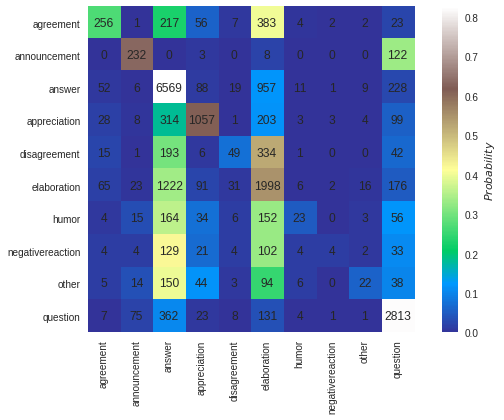

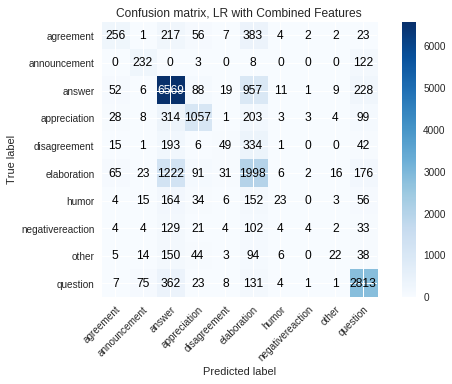

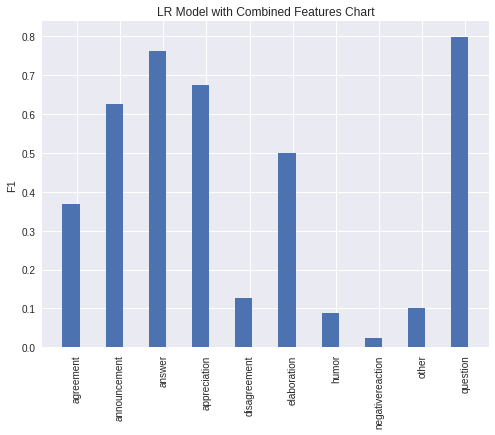

In [0]:
evaluation_summary("LR Combined Features", lr_final_prediction, test_labels_p2) 
plot_conf_matrix(test_labels_p2,lr_final_prediction, lr_final_model.classes_, title= 'Confusion Matrix')
plot_confusion_matrix(test_labels_p2, lr_final_prediction, classes=lr_final_model.classes_,title='Confusion matrix, LR with Combined Features')
create_plot('LR Model with Combined Features Chart', lr_final_model, lr_final_prediction, test_labels_p2)


### Feature performance

In [0]:
!pip install eli5

In [0]:
import eli5
eli5.show_weights(final_lr, top=20)